General ideas:
-----------------------------

Basically, use http://surpriselib.com/

* Baselines
    * Simpler ones -> Need to try with `surprise.prediction_algorithms.baseline_only.BaselineOnly(bsl_options={})`
        * Global mean :)
        * User mean   :)
        * Item mean   :)
    * Aditional
        * User rating depends on number of ratings
        * User rating depends on overall rating for the item

-----------------------------

From here on, use regularization! Better Ridge, maybe Lasso.

* Neighborhood models (http://surprise.readthedocs.io/en/stable/knn_inspired.html)
    * Find sets of similar users
    * Find sets of similar items
    * Correlation/Cosine similarity suggested in post (one for users, one for items)
* Matrix factorization. For sparse matrices. Non-negative elements. Missing elements are not the same as elements equal to 0. (!!!)
    * Standard SVD `surprise.prediction_algorithms.matrix_factorization.SVD`
    * Asymmetric SVD
    * SVD++ `surprise.prediction_algorithms.matrix_factorization.SVDpp`
    * NMF (already implemented, but not properly?) `surprise.prediction_algorithms.matrix_factorization.NMF`

-----------------------------

Put all together...

Ensemble methods (http://scikit-learn.org/stable/modules/ensemble.html)
* Linear regression
* Gradient boosted decision trees - can apply different methods to different slices of data! We can cluster by: (!!!)
    * Number of items rated
    * Number of users that rated the item
    * Factor vectors of users and items (?)

In [1]:
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import csv
from sklearn.decomposition import NMF

%load_ext autoreload
%autoreload 2
%matplotlib inline

from helpers import calculate_mse

# Load and prepare data

#### Load the Data
`ratings` is a sparse matrix in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

DATA_PATH = '../data/'
PREDICTION_PATH = '../data/predictions/'
ratings = load_data('{dp}data_train.csv'.format(dp=DATA_PATH))
#ratings = load_data('{dp}movielens100k.csv'.format(dp=DATA_PATH))

number of items: 10000, number of users: 1000


#### Plot the number of ratings per movie and user

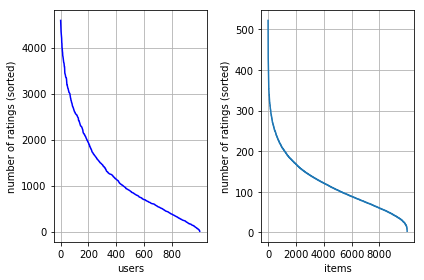

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

#### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1, verbose=False):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][:, valid_users]
    
    # LIL is a convenient format for constructing sparse matrices
    train = sp.lil_matrix(valid_ratings.shape)
    test = sp.lil_matrix(valid_ratings.shape)
    
    valid_ratings_i, valid_ratings_u, valid_ratings_v = sp.find(valid_ratings)
    valid_ratings_p_idx = np.random.permutation(range(len(valid_ratings_i)))
    
    n_test = int(p_test*len(valid_ratings_i))
    
    for idx in valid_ratings_p_idx[:n_test]:
        test[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]
        
    for idx in valid_ratings_p_idx[n_test:]:
        train[valid_ratings_i[idx], valid_ratings_u[idx]] = valid_ratings_v[idx]

    if verbose:
        print("Total number of nonzero elements in original data:{v}".format(v=ratings.nnz))
        print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
        print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    
    # convert to CSR for faster operations
    return valid_ratings, train.tocsr(), test.tocsr()

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)

# Auxiliary functions

In [6]:
def compute_division(a, b):
    """Computes element by element division.
    If x/0 returns 0.
    """
    # Raises error if vectors have different lengths
    assert(len(a) == len(b))
    
    # Computes division
    res = a.copy()
    for i in range(len(a)):
        if b[i] == 0:
            res[i] = 0
        else:
            res[i] = a[i] / b[i]

    return res

# Baselines 

#### Ex10 functions

Test implementations:

#### Project functions

In [7]:
# Baseline rating
def baseline_rating(data):
    """Implements baseline method using the global mean."""
    # Compute global mean using training data
    data_mean = data.sum() / data.count_nonzero()
    return data_mean


# User or item specific effect
def baseline_user_item_specific(data, mean):
    """Implements baseline method using either the user
    or the item mean, as indicated in parameter mean."""
    if mean=="user":
        flag = 1
        inv_flag = 0
    else:
        flag = 0
        inv_flag = 1

    num = data.shape[flag]
    
    # Obtain data_deviations, which are the ratings minus global avg
    global_mean = baseline_rating(data)
    data_deviations = data.copy()
    data_deviations.data = 1.0 * data_deviations.data
    data_deviations.data -= global_mean
    
    # Compute means using training data
    # get rows, columns and values for elements in data_deviations
    data_rcv = sp.find(data_deviations)
    counts = np.bincount(data_rcv[flag], minlength=num)
    sums = np.bincount(data_rcv[flag], weights=data_rcv[2], minlength=num)
    means = compute_division(sums, counts)

    return means

#### Predict using global mean

#### Predict using global, user and item means (baseline)

We first estimate the RMSE for our test set:

In [8]:
def train_model_baseline(data, test_data, test_flag, sub_flag=False,
    sub_filename="new_submission", verbose=False):

    """If 'test_flag' is True, then 'data' should be the training dataset
    'test_data' the test dataset. In this case sub_flag is ignored.
    
    If 'test_flag' is False and 'sub_flag' is True, then 'data' should be
    the entire ratings dataset and 'test_data' should be a sample submission.
    
    Both 'data' and 'test_data' should be csr sparse matrices.
    """
    assert test_flag or sub_flag, "Specify a task"
    
    global_mean = baseline_rating(data)
    user_means = baseline_user_item_specific(data, 'user')
    item_means = baseline_user_item_specific(data, 'item')
    
    (rows, cols, vals) = sp.find(test_data)
    
    if test_flag:        
        # Do predictions
        pred_test = vals.copy()
        pred_test = 1.0 * pred_test

        for (i, u) in zip(rows, cols):
            pred_i_u = global_mean + user_means[u] + item_means[i]
            pred_test[(rows==i) & (cols==u)] = pred_i_u

        # Compute and print test error
        test_mse = calculate_mse(vals, pred_test)
        test_rmse = np.sqrt(test_mse / len(vals))
        if verbose:
            print("Test RMSE of baseline using baseline: {e}".format(e=test_rmse)) 
        return test_rmse, pred_test

    elif sub_flag:
        # Directly write predictions to submission file
        with open('{dp}{fn}.csv'.format(dp=PREDICTION_PATH, fn=sub_filename), 'w') as csvfile:
            fieldnames = ['Id', 'Prediction']
            writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
            writer.writeheader()
            for (i, u) in zip(rows, cols):
                pred_i_u = global_mean + user_means[u] + item_means[i]
                writer.writerow({'Id':'r{r}_c{c}'.format(r=i+1,c=u+1),'Prediction':pred_i_u})

In [16]:
test_rmse, pred_test = train_model_baseline(train, test, True, verbose=True)

Test RMSE of baseline using baseline: 1.0057078177840963


Now we prepare the submission file training on all data:

In [17]:
ratings_csr = ratings.tocsr()
sample_submission = load_data('{dp}sample_submission.csv'.format(dp=DATA_PATH))
sample_submission_csr = sample_submission.tocsr()

train_model_baseline(ratings_csr, sample_submission_csr, False, True, "baselines_2")
# Achieves 1.00386 in Kaggle

number of items: 10000, number of users: 1000


# Matrix Factorization

In [13]:
def unbaseline_matrix(data, add_constant, verbose=False):
    """Removes the global, user and item means from a matrix.
    Returns the matrix and the computed means.
    """
    num_rows, num_cols = data.shape
    (rows, cols, vals) = sp.find(data)
    
    # Compute global, user and item means 
    global_mean = baseline_rating(data)
    user_means = baseline_user_item_specific(data, 'user')
    item_means = baseline_user_item_specific(data, 'item') 
    
    # Substract the baseline of each element in 'data'
    train_vals = vals.copy()
    train_vals = 1.0 * train_vals

    for (i, u) in zip(rows, cols):
        baseline_i_u = global_mean + user_means[u] + item_means[i]
        train_vals[(rows==i) & (cols==u)] += (- baseline_i_u)

    # Get matrix
    train_matrix = sp.csr_matrix((train_vals, (rows, cols)),
        shape=(num_rows, num_cols))
    
    train_matrix = train_matrix.todense() + add_constant
    
    if verbose:
        print('---------------------------------------------')
        print('          Completed unbaseline_matrix!       ')
        print('---------------------------------------------')
    
    return train_matrix, global_mean, user_means, item_means

The following function is stupid, keeping it for future reference:

In [14]:
def train_model_matrix_factorization(data, test_data, test_flag, sub_flag=False,
    sub_filename="new_submission", alpha=0, l1_ratio=0, shuffle=True, random_state=42,
    verbose=False):

    """If 'test_flag' is True, then 'data' should be the training dataset
    'test_data' the test dataset. In this case sub_flag is ignored.
    
    If 'test_flag' is False and 'sub_flag' is True, then 'data' should be
    the entire ratings dataset and 'test_data' should be a sample submission.
    
    Both 'data' and 'test_data' should be csr sparse matrices.
    """

    assert test_flag or sub_flag, "Specify a task"

    # Get matrix
    add_constant = 5
    train_matrix, global_mean, user_means, item_means = unbaseline_matrix(data, add_constant, verbose=verbose)
    
    # Create and fit model   
    nmf_model = NMF(alpha=alpha, l1_ratio=l1_ratio, shuffle=shuffle, random_state=random_state)
    W = nmf_model.fit_transform(train_matrix)
    H = nmf_model.components_
    W_csr = sp.csr_matrix(W)
    H_csr = sp.csr_matrix(H)
    prediction_matrix = W_csr.dot(H_csr)
    
    if verbose:
        print('Finished fitting model')

    (test_rows, test_cols, test_vals) = sp.find(test)

    if test_flag:        
        # Do predictions
        pred_test = test_vals.copy()
        pred_test = 1.0 * pred_test
        
        for (i, u) in zip(test_rows, test_cols):
            mat_fact_i_u = prediction_matrix[i,u]
            baseline_i_u = global_mean + user_means[u] + item_means[i]
            pred_i_u = mat_fact_i_u + baseline_i_u - add_constant
            
            pred_test[(test_rows==i) & (test_cols==u)] = pred_i_u
        
        if verbose:
            print('Finished predicting')

        # Compute and print test error
        test_mse = calculate_mse(test_vals, pred_test)
        test_rmse = np.sqrt(test_mse / len(vals))
        
        if verbose:
            print("Test RMSE using baseline and matrix factorization: {e}".format(e=test_rmse)) 
            print()
            print('---------------------------------------------')
            print(' Completed train_model_matrix_factorization! ')    
            print('---------------------------------------------')
            
        return test_rmse, pred_test

    elif sub_flag:
        # Directly write predictions to submission file
        with open('{dp}{fn}.csv'.format(dp=PREDICTION_PATH, fn=sub_filename), 'w') as csvfile:
            fieldnames = ['Id', 'Prediction']
            writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
            writer.writeheader()
            
            for (i, u) in zip(test_rows, test_cols):  
                pred_i_u = prediction_matrix[i,u]
                baseline_i_u = global_mean + user_means[u] + item_means[i]
                pred_i_u = mat_fact_i_u + baseline_i_u - add_constant
                writer.writerow({'Id':'r{r}_c{c}'.format(r=i+1,c=u+1),'Prediction':pred_i_u})
                
        if verbose:
            print('---------------------------------------------')
            print(' Completed train_model_matrix_factorization! ')    
            print('---------------------------------------------')

Very simple example to try new functions on:

In [15]:
nrows, ncols = (4,3)
a=np.random.randint(0,7,(nrows,ncols))
a[a>5]=0
a=sp.csr_matrix(a)
print(a.todense())
print()
a_unbiased, gm, um, im = unbaseline_matrix(a, 5)
print(a_unbiased)
print()

nmf_model = NMF(alpha=0, l1_ratio=0, shuffle=True, random_state=1)
W = nmf_model.fit_transform(a_unbiased)
H = nmf_model.components_

prediction_matrix=W.dot(H)
print()
print(W)
print(H)

pred_sol = np.full((nrows,ncols),1.0)

for i in range(nrows):
    for u in range(ncols):
        mat_fact_i_u = prediction_matrix[i,u]
        baseline_i_u = gm + um[u] + im[i]
        pred_i_u = mat_fact_i_u - 5 #+ baseline_i_u

        pred_sol[i,u] = pred_i_u
        #print('i{} u{} mf{} bl{} p{}'.format(i,u,mat_fact_i_u,baseline_i_u,pred_i_u))

print()
print(pred_sol)

[[0 1 5]
 [0 0 0]
 [5 5 5]
 [0 0 0]]

[[ 5.   4.2  6.2]
 [ 5.   5.   5. ]
 [ 4.2  6.2  4.2]
 [ 5.   5.   5. ]]


[[ 0.03641587  1.51648764  1.74237048]
 [ 0.96930122  1.0870609   1.41196685]
 [ 2.14769667  0.85292491  0.57534788]
 [ 0.96875635  1.08721456  1.41241006]]
[[ 1.09664948  1.96432528  0.46772394]
 [ 0.58789681  1.75436479  3.27679007]
 [ 2.33525906  0.84236006  0.69682997]]

[[  3.60139476e-04  -8.00291573e-01   1.20038018e+00]
 [ -6.28316951e-04   5.08731207e-04  -6.63440377e-04]
 [ -7.99711403e-01   1.19976635e+00  -7.99695346e-01]
 [ -1.00513528e-04   8.13373699e-05  -1.05940336e-04]]


Train some real models:

In [13]:
ratings_csr = ratings.tocsr()
sample_submission = load_data('{dp}sample_submission.csv'.format(dp=DATA_PATH))
sample_submission_csr = sample_submission.tocsr()

number of items: 10000, number of users: 1000


(no models to train, sadly...)

# Matrix Factorization for Ex10

### Matrix Factorization using SGD

Some guy wanted to optimize running time, this is his code:

https://codereview.stackexchange.com/questions/35727/optimize-scipy-sparse-matrix-factorization-code-for-sgd

In [ ]:
N = self.model.shape[0] #no of users
M = self.model.shape[1] #no of items
self.p = np.random.rand(N, K)
self.q = np.random.rand(M, K)
rows,cols = self.model.nonzero()        
for step in xrange(steps):
    for u, i in zip(rows,cols):
        e = self.model[u, i] - np.dot(self.p[u, :], self.q[i, :]) #calculate error for gradient
        p_temp = learning_rate * ( e * self.q[i,:] - regularization * self.p[u,:])
        self.q[i,:]+= learning_rate * ( e * self.p[u,:] - regularization * self.q[i,:])
        self.p[u,:] += p_temp

#### Initialize matrix factorization

In [ ]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [ ]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    raise NotImplementedError

In [ ]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO
        # do matrix factorization.
        # ***************************************************
        raise NotImplementedError

        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    raise NotImplementedError

matrix_factorization_SGD(train, test)   

### Learn the Matrix Factorization using Alternating Least Squares

In [ ]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return user feature.
    # ***************************************************
    raise NotImplementedError

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # update and return item feature.
    # ***************************************************
    raise NotImplementedError

In [ ]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # start you ALS-WR algorithm.
    # ***************************************************
    raise NotImplementedError

ALS(train, test)